In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt
from pandas import DataFrame
import pickle as pickle
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
#from gensim.models.word2vec import Word2Vec
from sklearn import preprocessing,metrics 
pd.set_option("display.max_columns", 100)
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import average_precision_score, classification_report,confusion_matrix
from scipy.stats import skew
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk import word_tokenize
from sklearn.multiclass import OneVsRestClassifier


In [2]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data = pd.read_csv('train.csv').fillna(' ')
label= data[['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']]

In [3]:
print(data.shape)

(159571, 8)


In [4]:
comment=data['comment_text']
x = [len(word_tokenize(comment[i])) for i in range(comment.shape[0])]

Average length of comment: 80.326


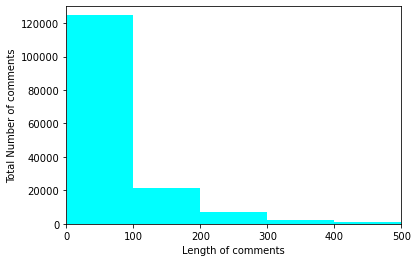

In [5]:
print('Average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,100,200,300,400,500]
plt.hist(x, bins=bins,color='aqua')
plt.xlabel('Length of comments')
plt.ylabel('Total Number of comments')       
plt.axis([0, 500, 0, 130000])
plt.show()

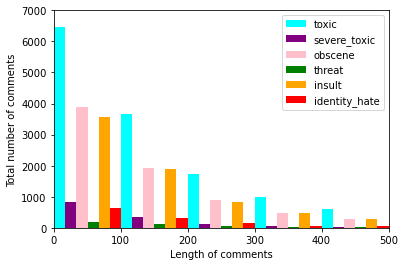

In [6]:
label=np.array(label)
y = np.zeros(label.shape)
for ix in range(comment.shape[0]):
    l = len(comment[ix])
    if label[ix][0] :
        y[ix][0] = l
    if label[ix][1] :
        y[ix][1] = l
    if label[ix][2] :
        y[ix][2] = l
    if label[ix][3] :
        y[ix][3] = l
    if label[ix][4] :
        y[ix][4] = l
    if label[ix][5] :
        y[ix][5] = l

color = ['aqua','purple','pink','green','orange','red']        
plt.hist(y,bins = bins,label = classes,color = color, rwidth=5)
plt.axis([0, 500, 0, 7000])
plt.xlabel('Length of comments')
plt.ylabel('Total number of comments') 
plt.legend()
plt.show()

In [7]:
data['comment_text'].fillna("missing", inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data["comment_text"],data[classes],test_size=0.1,random_state=76)
data_text = pd.concat([X_train,X_test])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
data.describe()

(143613,)
(15958,)
(143613, 6)
(15958, 6)


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(data_text))
X_traint = tokenizer.texts_to_sequences(X_train)
X_testt = tokenizer.texts_to_sequences(X_test)

In [9]:
#glove embedding
GLOVE_6B_100D_PATH = "glove.6B.300d.txt"
index_len = len(tokenizer.word_index)
print(index_len)
glove = {}
dimension = 300
glove_matrix = np.zeros((index_len+1,dimension))
glove_path = open(GLOVE_6B_100D_PATH, errors='ignore',encoding='utf8')
print(glove_path)
# cnt=0
for line in tqdm(glove_path):
    line_arr = line.split()
    word = line_arr[0]
    glove[word] = np.asarray(line_arr[1:], dtype='float32')
    
glove_path.close()
for word, idx in tqdm(tokenizer.word_index.items()):
    if word in glove: 
        glove_matrix[idx] = glove[word]

76it [00:00, 654.81it/s]

210337
<_io.TextIOWrapper name='glove.6B.300d.txt' mode='r' encoding='utf8'>


400000it [00:58, 6820.04it/s]
100%|██████████████████████████████████████████████████████████████████████| 210337/210337 [00:00<00:00, 360078.71it/s]


In [10]:
#normalization 
nltk.download('punkt')
nltk.download('stopwords')
porter = PorterStemmer()
sw = set(stopwords.words('english'))
sw.update(['.', "'", '(', ')', '[', ']', '{', '}'',', '"', ':', ';'])
def vectorize(s):
    words = str(s).lower()
    tokenized = word_tokenize(words)
    updated_tokens=[]
    final_tokens = []
    for word in tokenized:
        if not word in sw and word.isalpha(): 
            updated_tokens.append(word)
    for token in updated_tokens:
        try:
            final_tokens.append(glove[token])
        except:
            continue  
    final_tokens = np.array(final_tokens)
    total =  final_tokens.sum(axis=0)
    data_type = type(total)
    if data_type != np.ndarray: return np.zeros(dimension)
    denom = np.sqrt((total ** 2).sum())
    return total / denom

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Akash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Akash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#padding 
X_train_lstm = pad_sequences(X_traint, maxlen=80)
X_test_lstm = pad_sequences(X_testt, maxlen=80)
X_train_base = [vectorize(sentence) for sentence in tqdm(X_train)]
X_test_base = [vectorize(sentence) for sentence in tqdm(X_test)]

100%|██████████████████████████████████████████████████████████████████████████| 15958/15958 [00:14<00:00, 1075.75it/s]


In [12]:
def evaluate_score(Y_test,predict): 
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    try : 
        loss = log_loss(Y_test,predict)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))
    return accuracy,loss

In [13]:
# xg_train=np.array(xg_train)
# print(np.shape(xg_train))
# print(y_train.shape)

max1=0
for i in range(len(X_train_base)):
    max1=max(max1,len(X_train_base[i]))
    
x_train=np.zeros([len(X_train_base),max1])

for i in range(len(X_train_base)):
    max1=max(max1,len(X_train_base[i]))
    for j in range(len(X_train_base[i])):
        x_train[i][j]=X_train_base[i][j]

print(max1)
print(x_train.shape)

x_test=np.zeros([len(X_test_base),max1])
max1=0
for i in range(len(X_test_base)):
    max1=max(max1,len(X_test_base[i]))
    for j in range(len(X_test_base[i])):
#         print(j)
        x_test[i][j]=X_test_base[i][j]

print(max1)
print(x_test.shape)


300
(143613, 300)
300
(15958, 300)


In [14]:
#Bi-lstm model
model_len = 80
model_bilstm = Sequential()
model_bilstm.add(Embedding(index_len + 1, dimension, weights = [glove_matrix], input_length = model_len, trainable = False))
model_bilstm.add(Bidirectional(LSTM(100, return_sequences = True)))
model_bilstm.add(GlobalMaxPool1D())
model_bilstm.add(BatchNormalization())
model_bilstm.add(Dropout(0.15))
model_bilstm.add(Dense(100, activation = "relu"))
model_bilstm.add(Dropout(0.15))
model_bilstm.add(Dense(70, activation = "relu"))
model_bilstm.add(Dropout(0.15))
model_bilstm.add(Dense(35, activation = "relu"))
model_bilstm.add(Dropout(0.15))
model_bilstm.add(Dense(6, activation = 'sigmoid'))
model_bilstm.summary()
model_bilstm.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(lr = 0.01), metrics = ['accuracy'])
bi_lstm = model_bilstm.fit(X_train_lstm, y_train, epochs = 2, batch_size = 128, validation_split = 0.25)
y_pred = model_bilstm.predict(X_test_lstm, verbose = 3, batch_size = 128) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 300)           63101400  
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 200)           320800    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

In [15]:
bilstm_acc,bilstm_loss=evaluate_score(y_test,y_pred.round())

Accuracy : 90.88231607970924
Log_loss : 1.8083453733889079


In [16]:
#lstm model
model_len = 80
model = Sequential()
model.add(Embedding(index_len + 1, dimension, weights = [glove_matrix], input_length = model_len, trainable = False))
model.add(LSTM(100, return_sequences = True))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.15))
model.add(Dense(70, activation = "relu"))
model.add(Dropout(0.15))
model.add(Dense(35, activation = "relu"))
model.add(Dropout(0.15))
model.add(Dense(6, activation = 'sigmoid'))
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(lr = 0.01), metrics = ['accuracy'])
lstm = model.fit(X_train_lstm, y_train, epochs = 2, batch_size = 128, validation_split = 0.25)
y_pred_lstm = model.predict(X_test_lstm, verbose = 3, batch_size = 128) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 300)           63101400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 80, 100)           160400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)              

In [17]:
# accuracy = accuracy_score(y_test, y_pred_lstm.round(), normalize=False)
# print(" Test Accuracy: %.2f%%" % ((accuracy * 100.0)/len(y_test)))
lstm_acc,lstm_loss=evaluate_score(y_test,y_pred_lstm.round())

Accuracy : 91.28336884321342
Log_loss : 1.4855391372040498


[0.06980462642500605, 0.0594791300783615]
[0.0699110212200647, 0.06188480398783882]


AttributeError: 'Line2D' object has no property 'colors'

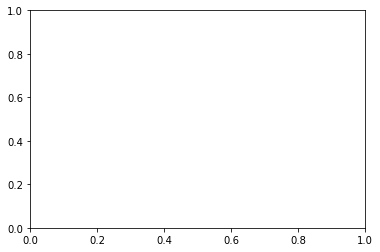

In [18]:

loss_results = DataFrame()
loss=list()
print(bi_lstm)
for i in bi_lstm.history['loss']:
    loss.append(i)
print(loss)
loss_results['Bi-lstm']=loss
loss.clear()
for i in lstm.history['loss']:
    loss.append(i)
print(loss)
loss_results['lstm']=loss
loss_results.plot(colors=['purple','orange'])
# ax=set_xlim(0,100000)
# ay=set_ylim(0,1)
plt.title('Training Loss')
plt.show()

In [ ]:
acc_results = DataFrame()
acc=list()
print(bi_lstm)
for i in bi_lstm.history['accuracy']:
    acc.append(i)
print(acc)
acc_results['Bi-lstm']=acc
acc.clear()
for i in lstm.history['accuracy']:
    acc.append(i)
print(acc)
acc_results['lstm']=acc
acc_results.plot(colors=['purple','orange'])
# ax=set_xlim(0,100000)
# ay=set_ylim(0,1)
plt.title('Training Accuracy')
plt.show()

In [ ]:
val_loss_results = DataFrame()
val_loss=list()
print(bi_lstm)
for i in bi_lstm.history['val_loss']:
    val_loss.append(i)
print(val_loss)
val_loss_results['lstm']=val_loss
val_loss.clear()
for i in lstm.history['val_loss']:
    val_loss.append(i)
print(val_loss)
val_loss_results['Bi-lstm']=val_loss
val_loss_results.plot(colors=['orange','purple'])
# ax=set_xlim(0,100000)
# ay=set_ylim(0,1)
plt.title('Validation Loss')
plt.show()

In [ ]:
val_acc_results = DataFrame()
val_acc=list()
print(bi_lstm)
for i in bi_lstm.history['val_accuracy']:
    val_acc.append(i)
print(val_acc)
val_acc_results['lstm']=val_acc
val_acc.clear()
for i in lstm.history['val_accuracy']:
    val_acc.append(i)
print(val_acc)
val_acc_results['Bi-lstm']=val_acc
val_acc_results.plot(colors=['orange','purple'])
# ax=set_xlim(0,100000)
# ay=set_ylim(0,1)
plt.title('Validation Accuracy')
plt.show()